In [1]:
import numpy as np  # 引入numpy、pandas库
import pandas as pd
from dbfread import DBF
from pandas import DataFrame
import matplotlib.pyplot as plt
import proplot as plot
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from IPython.display import display
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter  # 刻度格式
import matplotlib.ticker as mticker  # 添加网格线
import math
from matplotlib import patches

pd.options.display.max_columns = None


In [2]:
path = "./data/IBTrACS.since1980.list.v04r00.lines.dbf"
df_raw = pd.DataFrame(iter(DBF(path)))

In [15]:
df = df_raw[(df_raw['USA_STATUS'] != "EX") 
            & (df_raw['USA_STATUS'] != "SS") 
            & (df_raw['USA_STATUS'] != "PT") 
            & (df_raw['USA_STATUS'] != "IN")
            & (df_raw['USA_STATUS'] != "DS") 
            & (df_raw['USA_STATUS'] != "WV")
            & (df_raw['USA_STATUS'] != "ET") 
            & (df_raw['USA_STATUS'] != "MD") 
            & (df_raw['USA_STATUS'] != "XX")]# 去掉表格属性USA_STATUS为EX的数据

In [17]:
df = df[df['DIST2LAND'] > 0]

In [20]:
df['DIST2LAND'].shape

(249226,)

In [21]:
def filter_indesity(df_, year, indensity):
    """
    df:
    int year: year
    indensity: 台风大小
    return 返回满足年份year台风大小大于34的台风编号列表 以及最小台风大小
    """
    df_year = df_[df_['year'] == year]
    Typh_times = df_year['NUMBER'].value_counts().sort_index().reset_index() # 每个台风出现的次数
    Typh_times.rename(columns={'NUMBER': 'times'})
    ls_num_indensity = []
    ls_min = []
    ls_max = []
    for typh_num in Typh_times['index']:
        df_typh_num = df_year[df_year['NUMBER'] == typh_num]
        typh_num_max = df_typh_num['USA_WIND'].max()
    #     print("The No. %d maxium is %.2f" %(typh_num, typh_num_max))
        if math.isnan(typh_num_max) is False:
            if typh_num_max > indensity:
                ls_wind_indesity = list(df_typh_num['USA_WIND'])
                length_indesity = len(ls_wind_indesity)
                typh_num_min = df_typh_num['USA_WIND'].min()
                df_indesity_min = df_typh_num[df_typh_num['USA_WIND'] == typh_num_min]
                min_times = df_indesity_min['USA_WIND'].value_counts()
                min_times = min_times[int(typh_num_min)]
                ls_num_indensity.append(typh_num)
                ls_min.append(typh_num_min) 
                ls_max.append(typh_num_max)

    return ls_num_indensity, ls_min, ls_max

def filter_min_and_max(df_, year, num):
    """
    int TpyhoneNomber:  num
    return 返回当前year年份的编号为num的最小台风数据和最大台风数据 dataframe
    """
    df_year = df_[df_['year'] == year]
    df_typh_num = df_year[df_year['NUMBER'] == num]
    typh_num_max = df_typh_num['USA_WIND'].max() # 查找最大值
#     print("The No. %d maxium is %.2f" %(typh_num, typh_num_max))

    ls_wind_indesity = list(df_typh_num['USA_WIND']) #列出台风风速的列表
    # length_indesity = len(ls_wind_indesity)  # 求长度
    typh_num_min = df_typh_num['USA_WIND'].min() # 找出最小台风风速

    df_indesity_min = df_typh_num[df_typh_num['USA_WIND'] == typh_num_min] # 设置最小台风风速的dataframe结构
    # min_counts = df_indesity_min['USA_WIND'].value_counts() #计算最小值出现了多少次
    # min_counts[int(typh_num_min)]
    # df_indesity_min[:1]

    df_indesity_max = df_typh_num[df_typh_num['USA_WIND'] == typh_num_max] # 设置最大台风风速的dataframe结构
    return df_indesity_min, df_indesity_max


def lat_and_lon_usa_wind_speed(df_, year_list):
    """
    year_list: einino, lanina, neutrual
    返回风速最小值和最大值表格
    """
    df_wind_speed_min = pd.DataFrame(columns=["SEASON", "NUMBER", "LAT", "LON", "USA_WIND"])
    df_wind_speed_max = pd.DataFrame(columns=["SEASON", "NUMBER", "LAT", "LON", "USA_WIND"])

    for year in year_list:
        ls_num_indensity_year, ls_min_year, ls_max_year = filter_indesity(df_, year, 64)
        for number, min_typh in zip(ls_num_indensity_year, ls_min_year):
            df_indesity_min, df_indesity_max = filter_min_and_max(df_, year, number)
            df_wind_speed_min = df_wind_speed_min.append(df_indesity_min[0:1].loc[df_indesity_min['USA_WIND'] == min_typh, ["SEASON", "NUMBER", "LAT", "LON", "USA_WIND"]], ignore_index=True)
        for number, max_typh in zip(ls_num_indensity_year, ls_max_year):
            df_indesity_min, df_indesity_max = filter_min_and_max(df_, year, number)
            df_wind_speed_max = df_wind_speed_max.append(df_indesity_max[0:1].loc[df_indesity_max['USA_WIND'] == max_typh, ["SEASON", "NUMBER", "LAT", "LON", "USA_WIND"]], ignore_index=True)
        
    return df_wind_speed_min, df_wind_speed_max

def basin_wind_speed(df_, basin, year_list):
    """
    返回风速最小值 风速最大值
    """
    df_tmp = df_[df_['BASIN'] == basin]
    df_year_wind_speed_min, df_year_wind_speed_max = lat_and_lon_usa_wind_speed(df_tmp, year_list)
    return df_year_wind_speed_min, df_year_wind_speed_max

def mean_lon_lat(df_):
    """
    返回经纬度的平局值 保留两位小数点
    """
    lon_mean = round(df_["LON"].mean(), 2)
    lat_mean = round(df_["LAT"].mean(), 2)
    return lon_mean, lat_mean

In [22]:

einino = [1982,1986,1987,1991,1994,1997,2002,2004,2009,2015]
lanina = [1988, 1995, 1998, 1998, 2000, 2007, 2010, 2011, 2016, 2020, 2021]
neutrual = [1983, 1984, 1985, 1989, 1990, 1992, 1993, 1995, 1996, 2001, 2003, 2005, 2006, 2008, 2012, 2013, 2014, 2017, 2018, 2019]


# basin = 'EP'  红色
df_einino_wind_speed_min_ep, df_einino_wind_speed_max_ep = basin_wind_speed(df, 'EP', einino)
# basin = "NA"  蓝色
df_einino_wind_speed_min_na, df_einino_wind_speed_max_na = basin_wind_speed(df, 'NA', einino)
# basin = "NI"  天蓝色
df_einino_wind_speed_min_ni, df_einino_wind_speed_max_ni = basin_wind_speed(df, 'NI', einino)
# basin = "SA"  绿色
df_einino_wind_speed_min_sa, df_einino_wind_speed_max_sa = basin_wind_speed(df, 'SA', einino)
# basin = "SI" 黑色
df_einino_wind_speed_min_si, df_einino_wind_speed_max_si = basin_wind_speed(df, 'SI', einino)
# basin = "SP" 紫色
df_einino_wind_speed_min_sp, df_einino_wind_speed_max_sp = basin_wind_speed(df, 'SP', einino)
# basin = "WP" 白色
df_einino_wind_speed_min_wp, df_einino_wind_speed_max_wp = basin_wind_speed(df, 'WP', einino)

AttributeError: type object 'object' has no attribute 'dtype'

In [34]:
df_einino_wind_speed_min_sp['LON'] = df_einino_wind_speed_min_sp['LON'].mask(df_einino_wind_speed_min_sp['LON'] < 0,
                                                                             (df_einino_wind_speed_min_sp['LON'] + 360))

def more_than_180(df_, col_name):
    df_[col_name] = df_[col_name].mask(df_[col_name]>180, (df_[col_name]-360))
    return df_[col_name]

AttributeError: 'PathCollection' object has no property 'bbox'

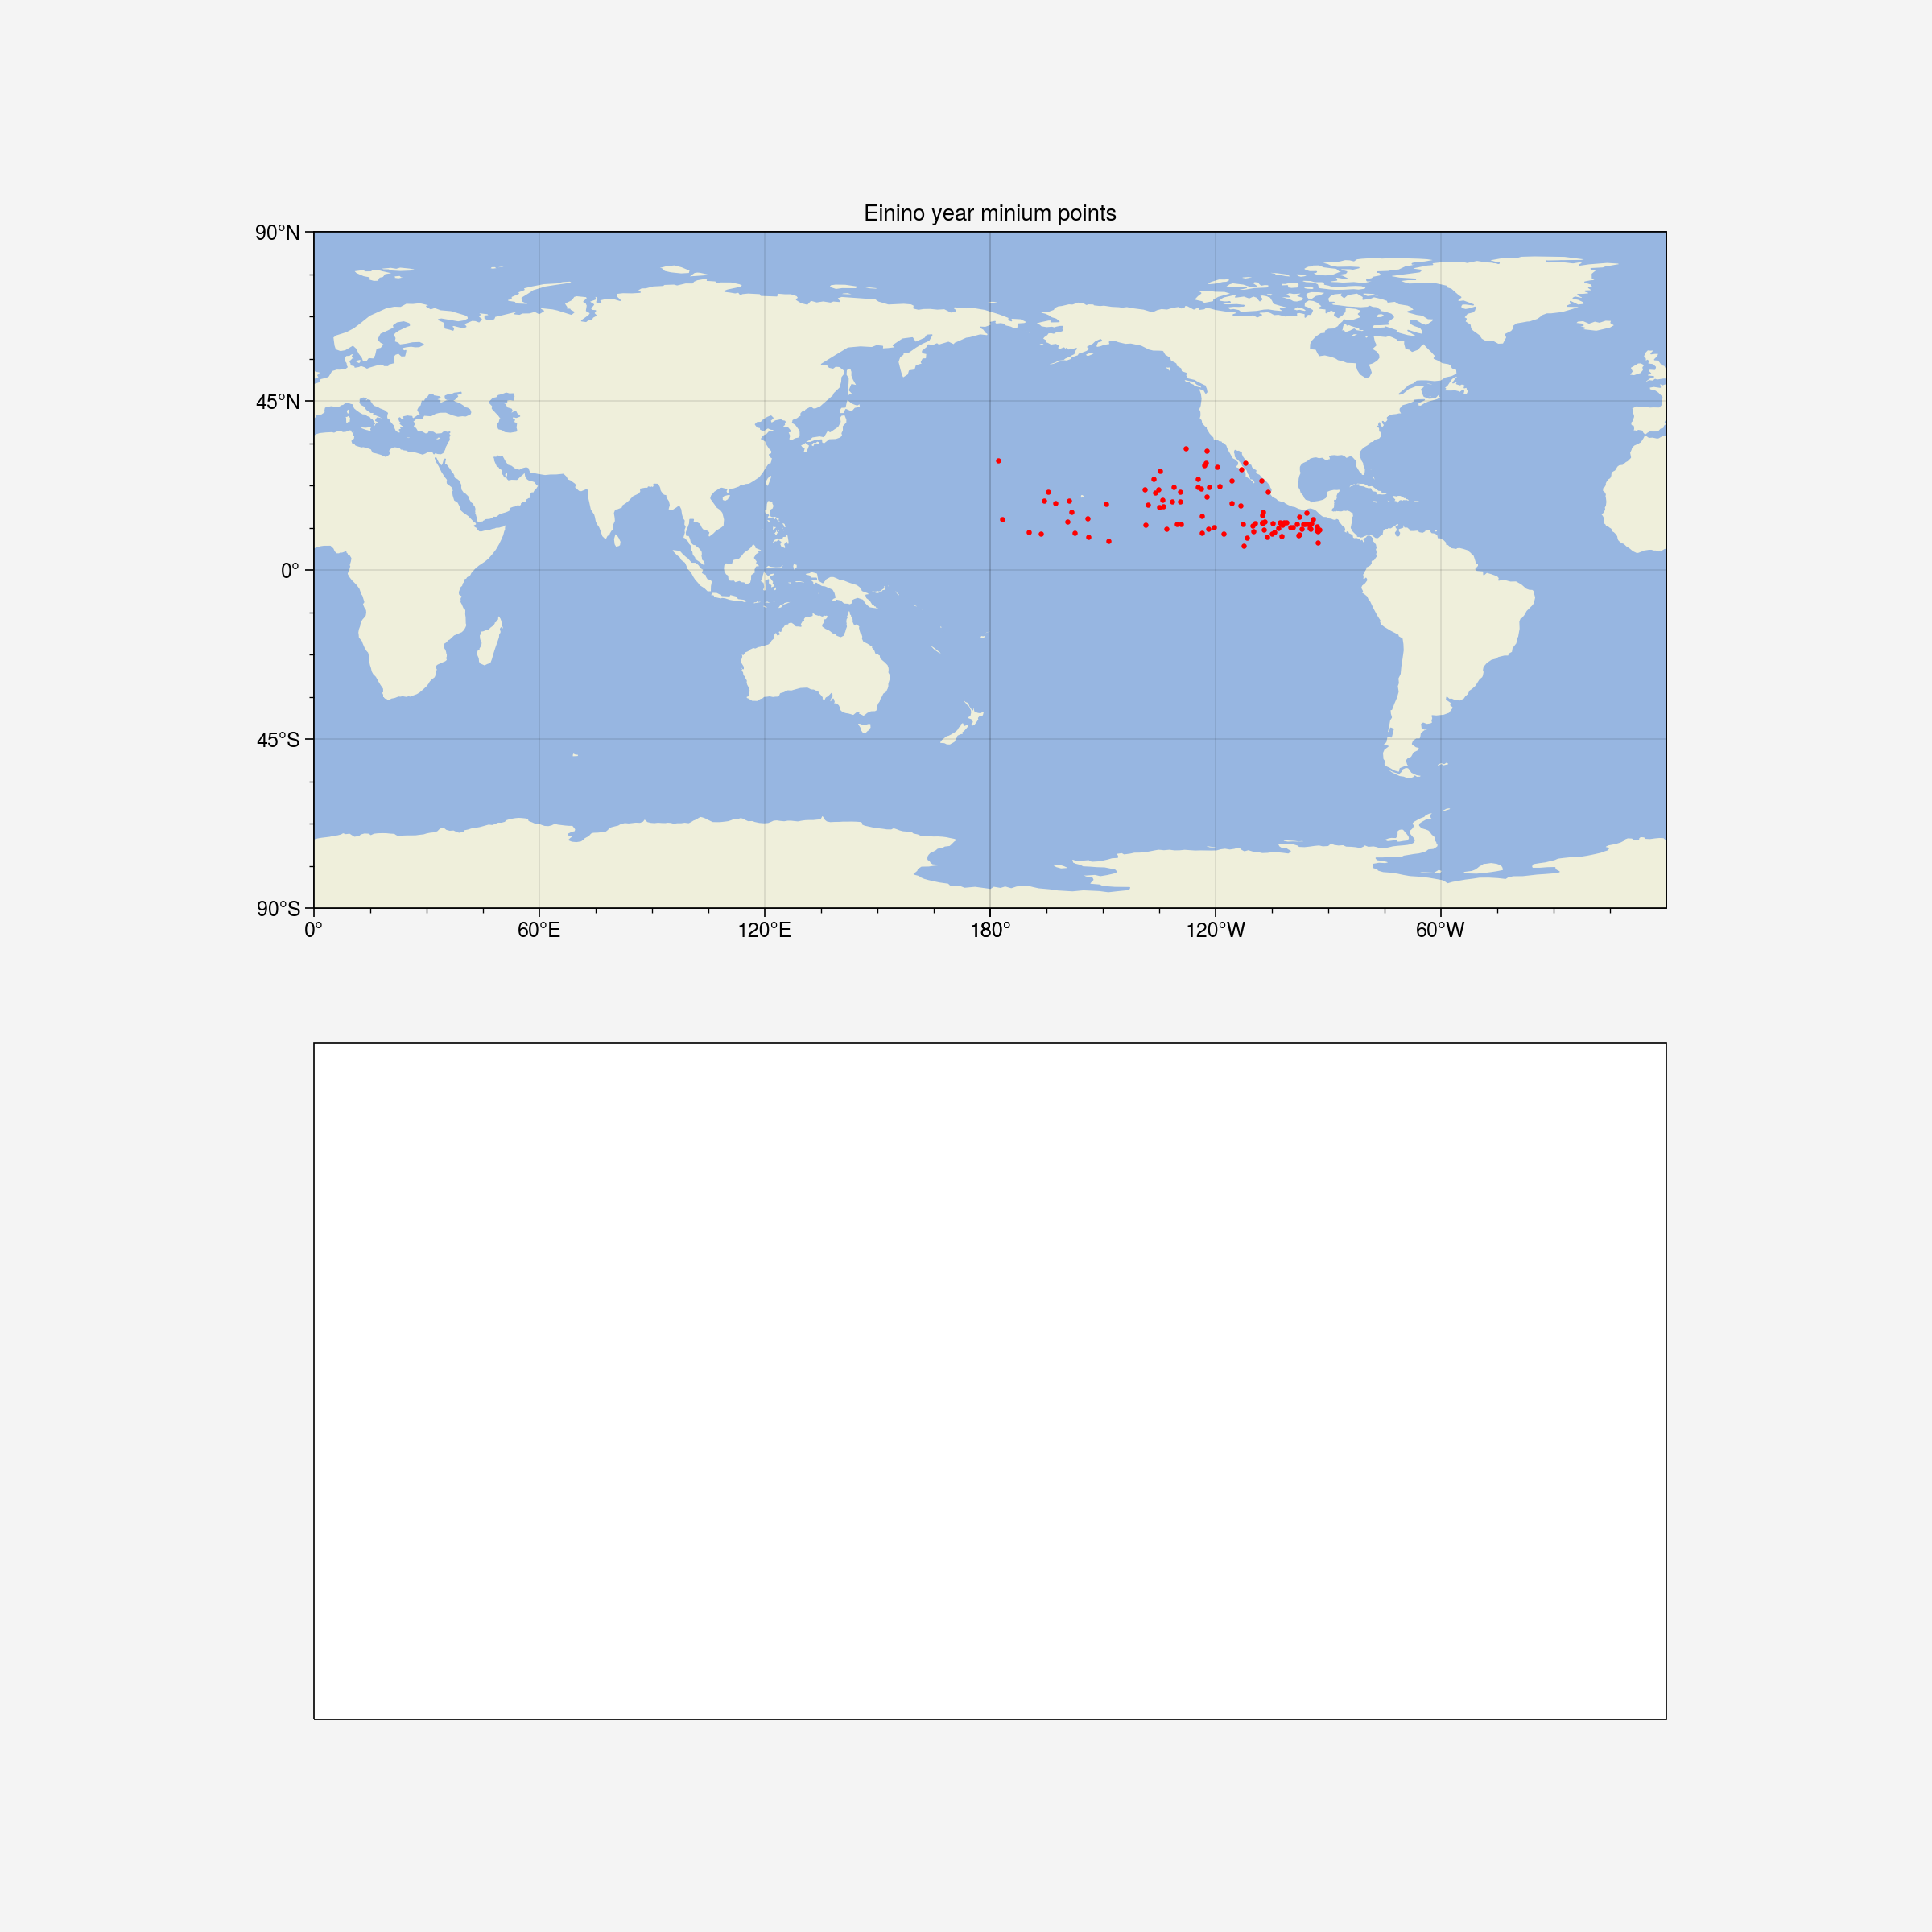

In [57]:
map_proj = ccrs.PlateCarree(central_longitude=180)
tick_proj = ccrs.PlateCarree(central_longitude=0)

fig, ax = plt.subplots(
    nrows=2, ncols=1, figsize=(12, 12),
    subplot_kw={'projection': map_proj}
)

ax =fig.add_subplot(2,1,1,projection=map_proj)
ax.set_global()
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.set_xticks(np.linspace(-180, 180, 7), crs=tick_proj)
ax.set_yticks(np.linspace(-90, 90, 5), crs=tick_proj)
ax.xaxis.set_major_formatter(LongitudeFormatter())
ax.yaxis.set_major_formatter(LatitudeFormatter())
ax.set_title("Einino year minium points")
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%     basin = 'EP'  红色
ax.scatter(df_einino_wind_speed_min_ep['LON'], df_einino_wind_speed_min_ep['LAT'],
        s=3, c = 'r', marker = 'o', label='EP',
        transform=ccrs.PlateCarree())
df_einino_wind_speed_min_ep['LON'] = more_than_180(df_einino_wind_speed_min_ep, 'LON')  # LON超过180度的那些点，规划到小于0中去
lon_mean_ep_min, lat_mean_ep_min = mean_lon_lat(df_einino_wind_speed_min_ep)
# 竖线
# ax.scatter([lon_mean_ep_min for _ in range(20)], 
#            np.arange(lat_mean_ep_min-10, lat_mean_ep_min + 10, 1).tolist(), 
#            s=3, c = 'r', marker = 'o', 
#         transform=ccrs.PlateCarree())
# 点
ax.scatter([lon_mean_ep_min], [lat_mean_ep_min],s=24, c = 'r', marker = 'o', bbox=dict(facecolor='sandybrown', alpha=0.5, boxstyle='round'),
        transform=ccrs.PlateCarree())

fig = plt.figure(figsize=[20, 20])


The Minium Wind average lon and lat point is (-120.43, 15.53) at Einino year in EP basin.
The Minium Wind average lon and lat point is (-62.18, 23.40) at Einino year in NA basin.
The Minium Wind average lon and lat point is (81.59, 11.47) at Einino year in NI basin.
The Minium Wind average lon and lat point is (82.77, -12.72) at Einino year in SI basin.
The Minium Wind average lon and lat point is (171.57, -12.14) at Einino year in SP basin.
The Minium Wind average lon and lat point is (150.05, 12.93) at Einino year in WP basin.
------分割线--------
The Maxium Wind average lon and lat point is (-123.72, 16.26) at Einino year in EP basin.
The Maxium Wind average lon and lat point is (-64.99, 27.57) at Einino year in NA basin.
The Maxium Wind average lon and lat point is (80.82, 16.77) at Einino year in NI basin.
The Maxium Wind average lon and lat point is (77.46, -16.92) at Einino year in SI basin.
The Maxium Wind average lon and lat point is (171.74, -17.04) at Einino year in SP basin.
T

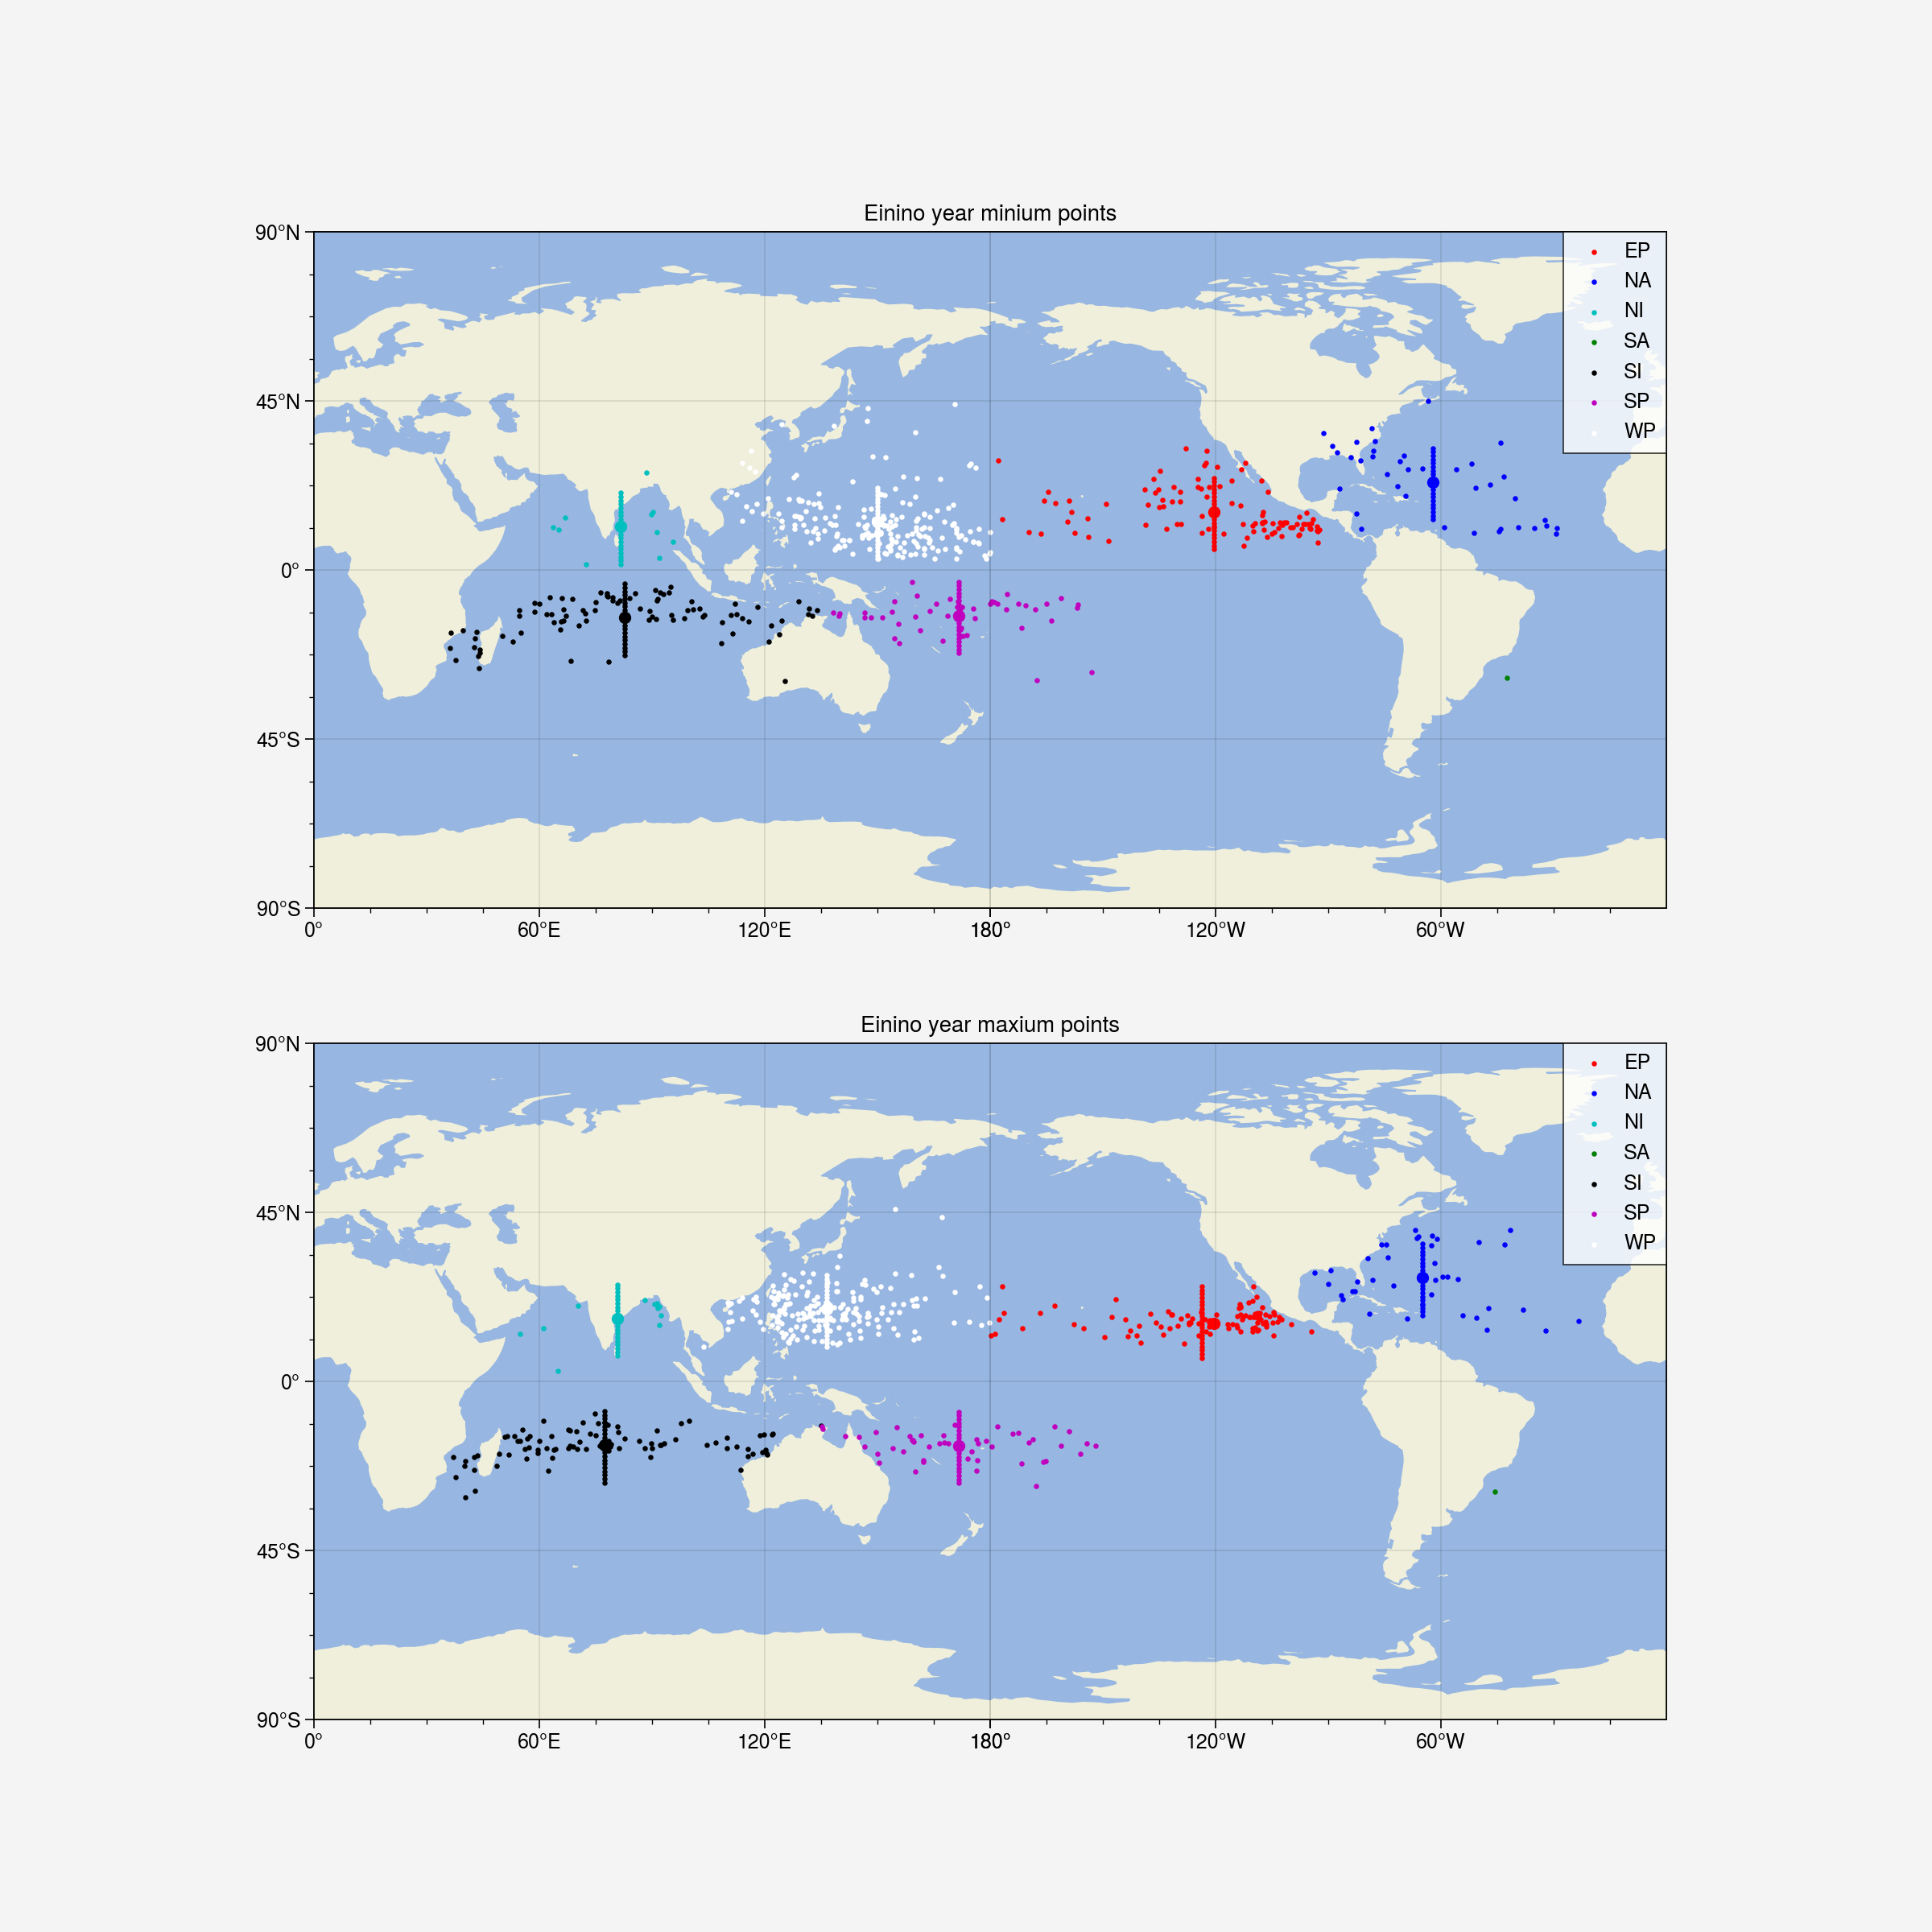

In [47]:
map_proj = ccrs.PlateCarree(central_longitude=180)
tick_proj = ccrs.PlateCarree(central_longitude=0)

fig, ax = plt.subplots(
    nrows=2, ncols=1, figsize=(12, 12),
    subplot_kw={'projection': map_proj}
)

ax =fig.add_subplot(2,1,1,projection=map_proj)
ax.set_global()
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.set_xticks(np.linspace(-180, 180, 7), crs=tick_proj)
ax.set_yticks(np.linspace(-90, 90, 5), crs=tick_proj)
ax.xaxis.set_major_formatter(LongitudeFormatter())
ax.yaxis.set_major_formatter(LatitudeFormatter())
ax.set_title("Einino year minium points")
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%     basin = 'EP'  红色
ax.scatter(df_einino_wind_speed_min_ep['LON'], df_einino_wind_speed_min_ep['LAT'],
        s=3, c = 'r', marker = 'o', label='EP',
        transform=ccrs.PlateCarree())
df_einino_wind_speed_min_ep['LON'] = more_than_180(df_einino_wind_speed_min_ep, 'LON')  # LON超过180度的那些点，规划到小于0中去
lon_mean_ep_min, lat_mean_ep_min = mean_lon_lat(df_einino_wind_speed_min_ep)
# 竖线
ax.scatter([lon_mean_ep_min for _ in range(20)], 
           np.arange(lat_mean_ep_min-10, lat_mean_ep_min + 10, 1).tolist(), 
           s=3, c = 'r', marker = 'o', 
        transform=ccrs.PlateCarree())
# 点
ax.scatter([lon_mean_ep_min], [lat_mean_ep_min],s=24, c = 'r', marker = 'o', 
        transform=ccrs.PlateCarree())

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%     basin = "NA"  蓝色
ax.scatter(df_einino_wind_speed_min_na['LON'], df_einino_wind_speed_min_na['LAT'],
        s=3, c = 'b', marker = 'o', label='NA',
        transform=ccrs.PlateCarree())
lon_mean_na_min, lat_mean_na_min = mean_lon_lat(df_einino_wind_speed_min_na)
# 竖线
ax.scatter([lon_mean_na_min for _ in range(20)], 
           np.arange(lat_mean_na_min-10, lat_mean_na_min + 10, 1).tolist(), 
           s=3, c = 'b', marker = 'o', 
        transform=ccrs.PlateCarree())
# 点
ax.scatter([lon_mean_na_min], [lat_mean_na_min],s=24, c = 'b', marker = 'o', 
        transform=ccrs.PlateCarree())

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%     basin = "NI"  天蓝色
ax.scatter(df_einino_wind_speed_min_ni['LON'], df_einino_wind_speed_min_ni['LAT'],
        s=3, c = 'c', marker = 'o', label='NI',
        transform=ccrs.PlateCarree())
lon_mean_ni_min, lat_mean_ni_min = mean_lon_lat(df_einino_wind_speed_min_ni)
# 竖线
ax.scatter([lon_mean_ni_min for _ in range(20)], 
           np.arange(lat_mean_ni_min-10, lat_mean_ni_min + 10, 1).tolist(), 
           s=3, c = 'c', marker = 'o', 
        transform=ccrs.PlateCarree())
# 点
ax.scatter([lon_mean_ni_min], [lat_mean_ni_min],s=24, c = 'c', marker = 'o', 
        transform=ccrs.PlateCarree())

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%     basin = "SA"  绿色
ax.scatter(df_einino_wind_speed_min_sa['LON'], df_einino_wind_speed_min_sa['LAT'],
        s=3, c = 'g', marker = 'o', label="SA",
        transform=ccrs.PlateCarree())

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%     basin = "SI" 黑色
ax.scatter(df_einino_wind_speed_min_si['LON'], df_einino_wind_speed_min_si['LAT'],
        s=3, c = 'k', marker = 'o', label='SI',
        transform=ccrs.PlateCarree())
lon_mean_si_min, lat_mean_si_min = mean_lon_lat(df_einino_wind_speed_min_si)
# 竖线
ax.scatter([lon_mean_si_min for _ in range(20)], 
           np.arange(lat_mean_si_min-10, lat_mean_si_min + 10, 1).tolist(), 
           s=3, c = 'k', marker = 'o', 
        transform=ccrs.PlateCarree())
# 点
ax.scatter([lon_mean_si_min], [lat_mean_si_min],s=24, c = 'k', marker = 'o', 
        transform=ccrs.PlateCarree())

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%     basin = "SP" 紫色
ax.scatter(df_einino_wind_speed_min_sp['LON'], df_einino_wind_speed_min_sp['LAT'],
        s=3, c = 'm', marker = 'o', label='SP',
        transform=ccrs.PlateCarree())
# 小于0的数均加上360
df_einino_wind_speed_min_sp['LON'] = df_einino_wind_speed_min_sp['LON'].mask(df_einino_wind_speed_min_sp['LON'] < 0,
                                                                             (df_einino_wind_speed_min_sp['LON'] + 360))
lon_mean_sp_min = round(df_einino_wind_speed_min_sp["LON"].mean(), 2)
lat_mean_sp_min = round(df_einino_wind_speed_min_sp["LAT"].mean(), 2)
# 竖线
ax.scatter([lon_mean_sp_min for _ in range(20)], 
           np.arange(lat_mean_sp_min-10, lat_mean_sp_min + 10, 1).tolist(), 
           s=3, c = 'm', marker = 'o', 
        transform=ccrs.PlateCarree())
# 点
ax.scatter([lon_mean_sp_min], [lat_mean_sp_min],s=24, c = 'm', marker = 'o', 
        transform=ccrs.PlateCarree())

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%     basin = "WP" 白色
ax.scatter(df_einino_wind_speed_min_wp['LON'], df_einino_wind_speed_min_wp['LAT'],
        s=3, c = 'w', marker = 'o',  label='WP',
        transform=ccrs.PlateCarree())
lon_mean_wp_min, lat_mean_wp_min = mean_lon_lat(df_einino_wind_speed_min_wp)
# 竖线
ax.scatter([lon_mean_wp_min for _ in range(20)], 
           np.arange(lat_mean_wp_min-10, lat_mean_wp_min + 10, 1).tolist(), 
           s=3, c = 'w', marker = 'o', 
        transform=ccrs.PlateCarree())
# 点
ax.scatter([lon_mean_wp_min], [lat_mean_wp_min],s=24, c = 'w', marker = 'o', 
        transform=ccrs.PlateCarree())
plt.legend()

# ================ 图2  ================
ax1 =fig.add_subplot(2,1,2,projection=map_proj)
ax1.set_global()
ax1.add_feature(cfeature.LAND)
ax1.add_feature(cfeature.OCEAN)
ax1.set_xticks(np.linspace(-180, 180, 7), crs=tick_proj)
ax1.set_yticks(np.linspace(-90, 90, 5), crs=tick_proj)
ax1.xaxis.set_major_formatter(LongitudeFormatter())
ax1.yaxis.set_major_formatter(LatitudeFormatter())
ax1.set_title("Einino year maxium points")
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%     basin = 'EP'  红色
ax1.scatter(df_einino_wind_speed_max_ep['LON'], df_einino_wind_speed_max_ep['LAT'],
        s=3, c = 'r', marker = 'o', label='EP',
        transform=ccrs.PlateCarree())
df_einino_wind_speed_max_ep['LON'] = more_than_180(df_einino_wind_speed_max_ep, 'LON')  # LON超过180度的那些点，规划到小于0中去
lon_mean_ep_max, lat_mean_ep_max = mean_lon_lat(df_einino_wind_speed_max_ep)
# 竖线
ax1.scatter([lon_mean_ep_max for _ in range(20)], 
           np.arange(lat_mean_ep_max-10, lat_mean_ep_max + 10, 1).tolist(), 
           s=3, c = 'r', marker = 'o', 
        transform=ccrs.PlateCarree())
# 点
ax1.scatter([lon_mean_ep_min], [lat_mean_ep_min],s=24, c = 'r', marker = 'o', 
        transform=ccrs.PlateCarree())

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%     basin = "NA"  蓝色
ax1.scatter(df_einino_wind_speed_max_na['LON'], df_einino_wind_speed_max_na['LAT'],
        s=3, c = 'b', marker = 'o', label='NA',
        transform=ccrs.PlateCarree())
lon_mean_na_max, lat_mean_na_max = mean_lon_lat(df_einino_wind_speed_max_na)
# 竖线
ax1.scatter([lon_mean_na_max for _ in range(20)], 
           np.arange(lat_mean_na_max-10, lat_mean_na_max + 10, 1).tolist(), 
           s=3, c = 'b', marker = 'o', 
        transform=ccrs.PlateCarree())
# 点
ax1.scatter([lon_mean_na_max], [lat_mean_na_max],s=24, c = 'b', marker = 'o', 
        transform=ccrs.PlateCarree())

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%     basin = "NI"  天蓝色
ax1.scatter(df_einino_wind_speed_max_ni['LON'], df_einino_wind_speed_max_ni['LAT'],
        s=3, c = 'c', marker = 'o', label='NI',
        transform=ccrs.PlateCarree())
lon_mean_ni_max, lat_mean_ni_max = mean_lon_lat(df_einino_wind_speed_max_ni)
# 竖线
ax1.scatter([lon_mean_ni_max for _ in range(20)], 
           np.arange(lat_mean_ni_max-10, lat_mean_ni_max + 10, 1).tolist(), 
           s=3, c = 'c', marker = 'o', 
        transform=ccrs.PlateCarree())
# 点
ax1.scatter([lon_mean_ni_max], [lat_mean_ni_max],s=24, c = 'c', marker = 'o', 
        transform=ccrs.PlateCarree())

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%     basin = "SA"  绿色
ax1.scatter(df_einino_wind_speed_max_sa['LON'], df_einino_wind_speed_max_sa['LAT'],
        s=3, c = 'g', marker = 'o', label="SA",
        transform=ccrs.PlateCarree())

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%     basin = "SI" 黑色
ax1.scatter(df_einino_wind_speed_max_si['LON'], df_einino_wind_speed_max_si['LAT'],
        s=3, c = 'k', marker = 'o', label='SI',
        transform=ccrs.PlateCarree())
lon_mean_si_max, lat_mean_si_max = mean_lon_lat(df_einino_wind_speed_max_si)
# 竖线
ax1.scatter([lon_mean_si_max for _ in range(20)], 
           np.arange(lat_mean_si_max-10, lat_mean_si_max + 10, 1).tolist(), 
           s=3, c = 'k', marker = 'o', 
        transform=ccrs.PlateCarree())
# 点
ax1.scatter([lon_mean_si_max], [lat_mean_si_max],s=24, c = 'k', marker = 'o', 
        transform=ccrs.PlateCarree())

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%     basin = "SP" 紫色
ax1.scatter(df_einino_wind_speed_max_sp['LON'], df_einino_wind_speed_max_sp['LAT'],
        s=3, c = 'm', marker = 'o', label='SP',
        transform=ccrs.PlateCarree())
# 小于0的数均加上360
df_einino_wind_speed_max_sp['LON'] = df_einino_wind_speed_max_sp['LON'].mask(df_einino_wind_speed_max_sp['LON'] < 0, (df_einino_wind_speed_max_sp['LON'] + 360))
lon_mean_sp_max = round(df_einino_wind_speed_max_sp["LON"].mean(), 2)
lat_mean_sp_max = round(df_einino_wind_speed_max_sp["LAT"].mean(), 2)
# 竖线
ax1.scatter([lon_mean_sp_max for _ in range(20)], 
           np.arange(lat_mean_sp_max-10, lat_mean_sp_max + 10, 1).tolist(), 
           s=3, c = 'm', marker = 'o', 
        transform=ccrs.PlateCarree())
# 点
ax1.scatter([lon_mean_sp_max], [lat_mean_sp_max],s=24, c = 'm', marker = 'o', 
        transform=ccrs.PlateCarree())

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%     basin = "WP" 白色
ax1.scatter(df_einino_wind_speed_max_wp['LON'], df_einino_wind_speed_max_wp['LAT'],
        s=3, c = 'w', marker = 'o', label='WP',
        transform=ccrs.PlateCarree())
lon_mean_wp_max, lat_mean_wp_max = mean_lon_lat(df_einino_wind_speed_max_wp)
# 竖线
ax1.scatter([lon_mean_wp_max for _ in range(20)], 
           np.arange(lat_mean_wp_max-10, lat_mean_wp_max + 10, 1).tolist(), 
           s=3, c = 'w', marker = 'o', 
        transform=ccrs.PlateCarree())
# 点
ax1.scatter([lon_mean_wp_max], [lat_mean_wp_max],s=24, c = 'w', marker = 'o', 
        transform=ccrs.PlateCarree())

plt.legend()

# fig = plt.figure(figsize=[20, 20])

print("The Minium Wind average lon and lat point is (%.2f, %.2f) at Einino year in EP basin."%(lon_mean_ep_min, lat_mean_ep_min))
print("The Minium Wind average lon and lat point is (%.2f, %.2f) at Einino year in NA basin."%(lon_mean_na_min, lat_mean_na_min))
print("The Minium Wind average lon and lat point is (%.2f, %.2f) at Einino year in NI basin."%(lon_mean_ni_min, lat_mean_ni_min))
print("The Minium Wind average lon and lat point is (%.2f, %.2f) at Einino year in SI basin."%(lon_mean_si_min, lat_mean_si_min))
print("The Minium Wind average lon and lat point is (%.2f, %.2f) at Einino year in SP basin."%(lon_mean_sp_min, lat_mean_sp_min))
print("The Minium Wind average lon and lat point is (%.2f, %.2f) at Einino year in WP basin."%(lon_mean_wp_min, lat_mean_wp_min))
print("------分割线--------")
print("The Maxium Wind average lon and lat point is (%.2f, %.2f) at Einino year in EP basin."%(lon_mean_ep_max, lat_mean_ep_max))
print("The Maxium Wind average lon and lat point is (%.2f, %.2f) at Einino year in NA basin."%(lon_mean_na_max, lat_mean_na_max))
print("The Maxium Wind average lon and lat point is (%.2f, %.2f) at Einino year in NI basin."%(lon_mean_ni_max, lat_mean_ni_max))
print("The Maxium Wind average lon and lat point is (%.2f, %.2f) at Einino year in SI basin."%(lon_mean_si_max, lat_mean_si_max))
print("The Maxium Wind average lon and lat point is (%.2f, %.2f) at Einino year in SP basin."%(lon_mean_sp_max, lat_mean_sp_max))
print("The Maxium Wind average lon and lat point is (%.2f, %.2f) at Einino year in WP basin."%(lon_mean_wp_max, lat_mean_wp_max))

The Minium Wind average lon and lat point is (-115.42, 16.05) at Lanina year in EP basin.
The Minium Wind average lon and lat point is (-57.97, 18.71) at Lanina year in NA basin.
The Minium Wind average lon and lat point is (83.22, 10.63) at Lanina year in NI basin.
The Minium Wind average lon and lat point is (93.64, -13.44) at Lanina year in SI basin.
The Minium Wind average lon and lat point is (175.78, -13.77) at Lanina year in SP basin.
The Minium Wind average lon and lat point is (140.85, 14.56) at Lanina year in WP basin.
------分割线--------
The Maxium Wind average lon and lat point is (-116.52, 17.18) at Lanina year in EP basin.
The Maxium Wind average lon and lat point is (-68.12, 23.98) at Lanina year in NA basin.
The Maxium Wind average lon and lat point is (78.77, 17.23) at Lanina year in NI basin.
The Maxium Wind average lon and lat point is (85.87, -17.80) at Lanina year in SI basin.
The Maxium Wind average lon and lat point is (175.94, -17.69) at Lanina year in SP basin.
T

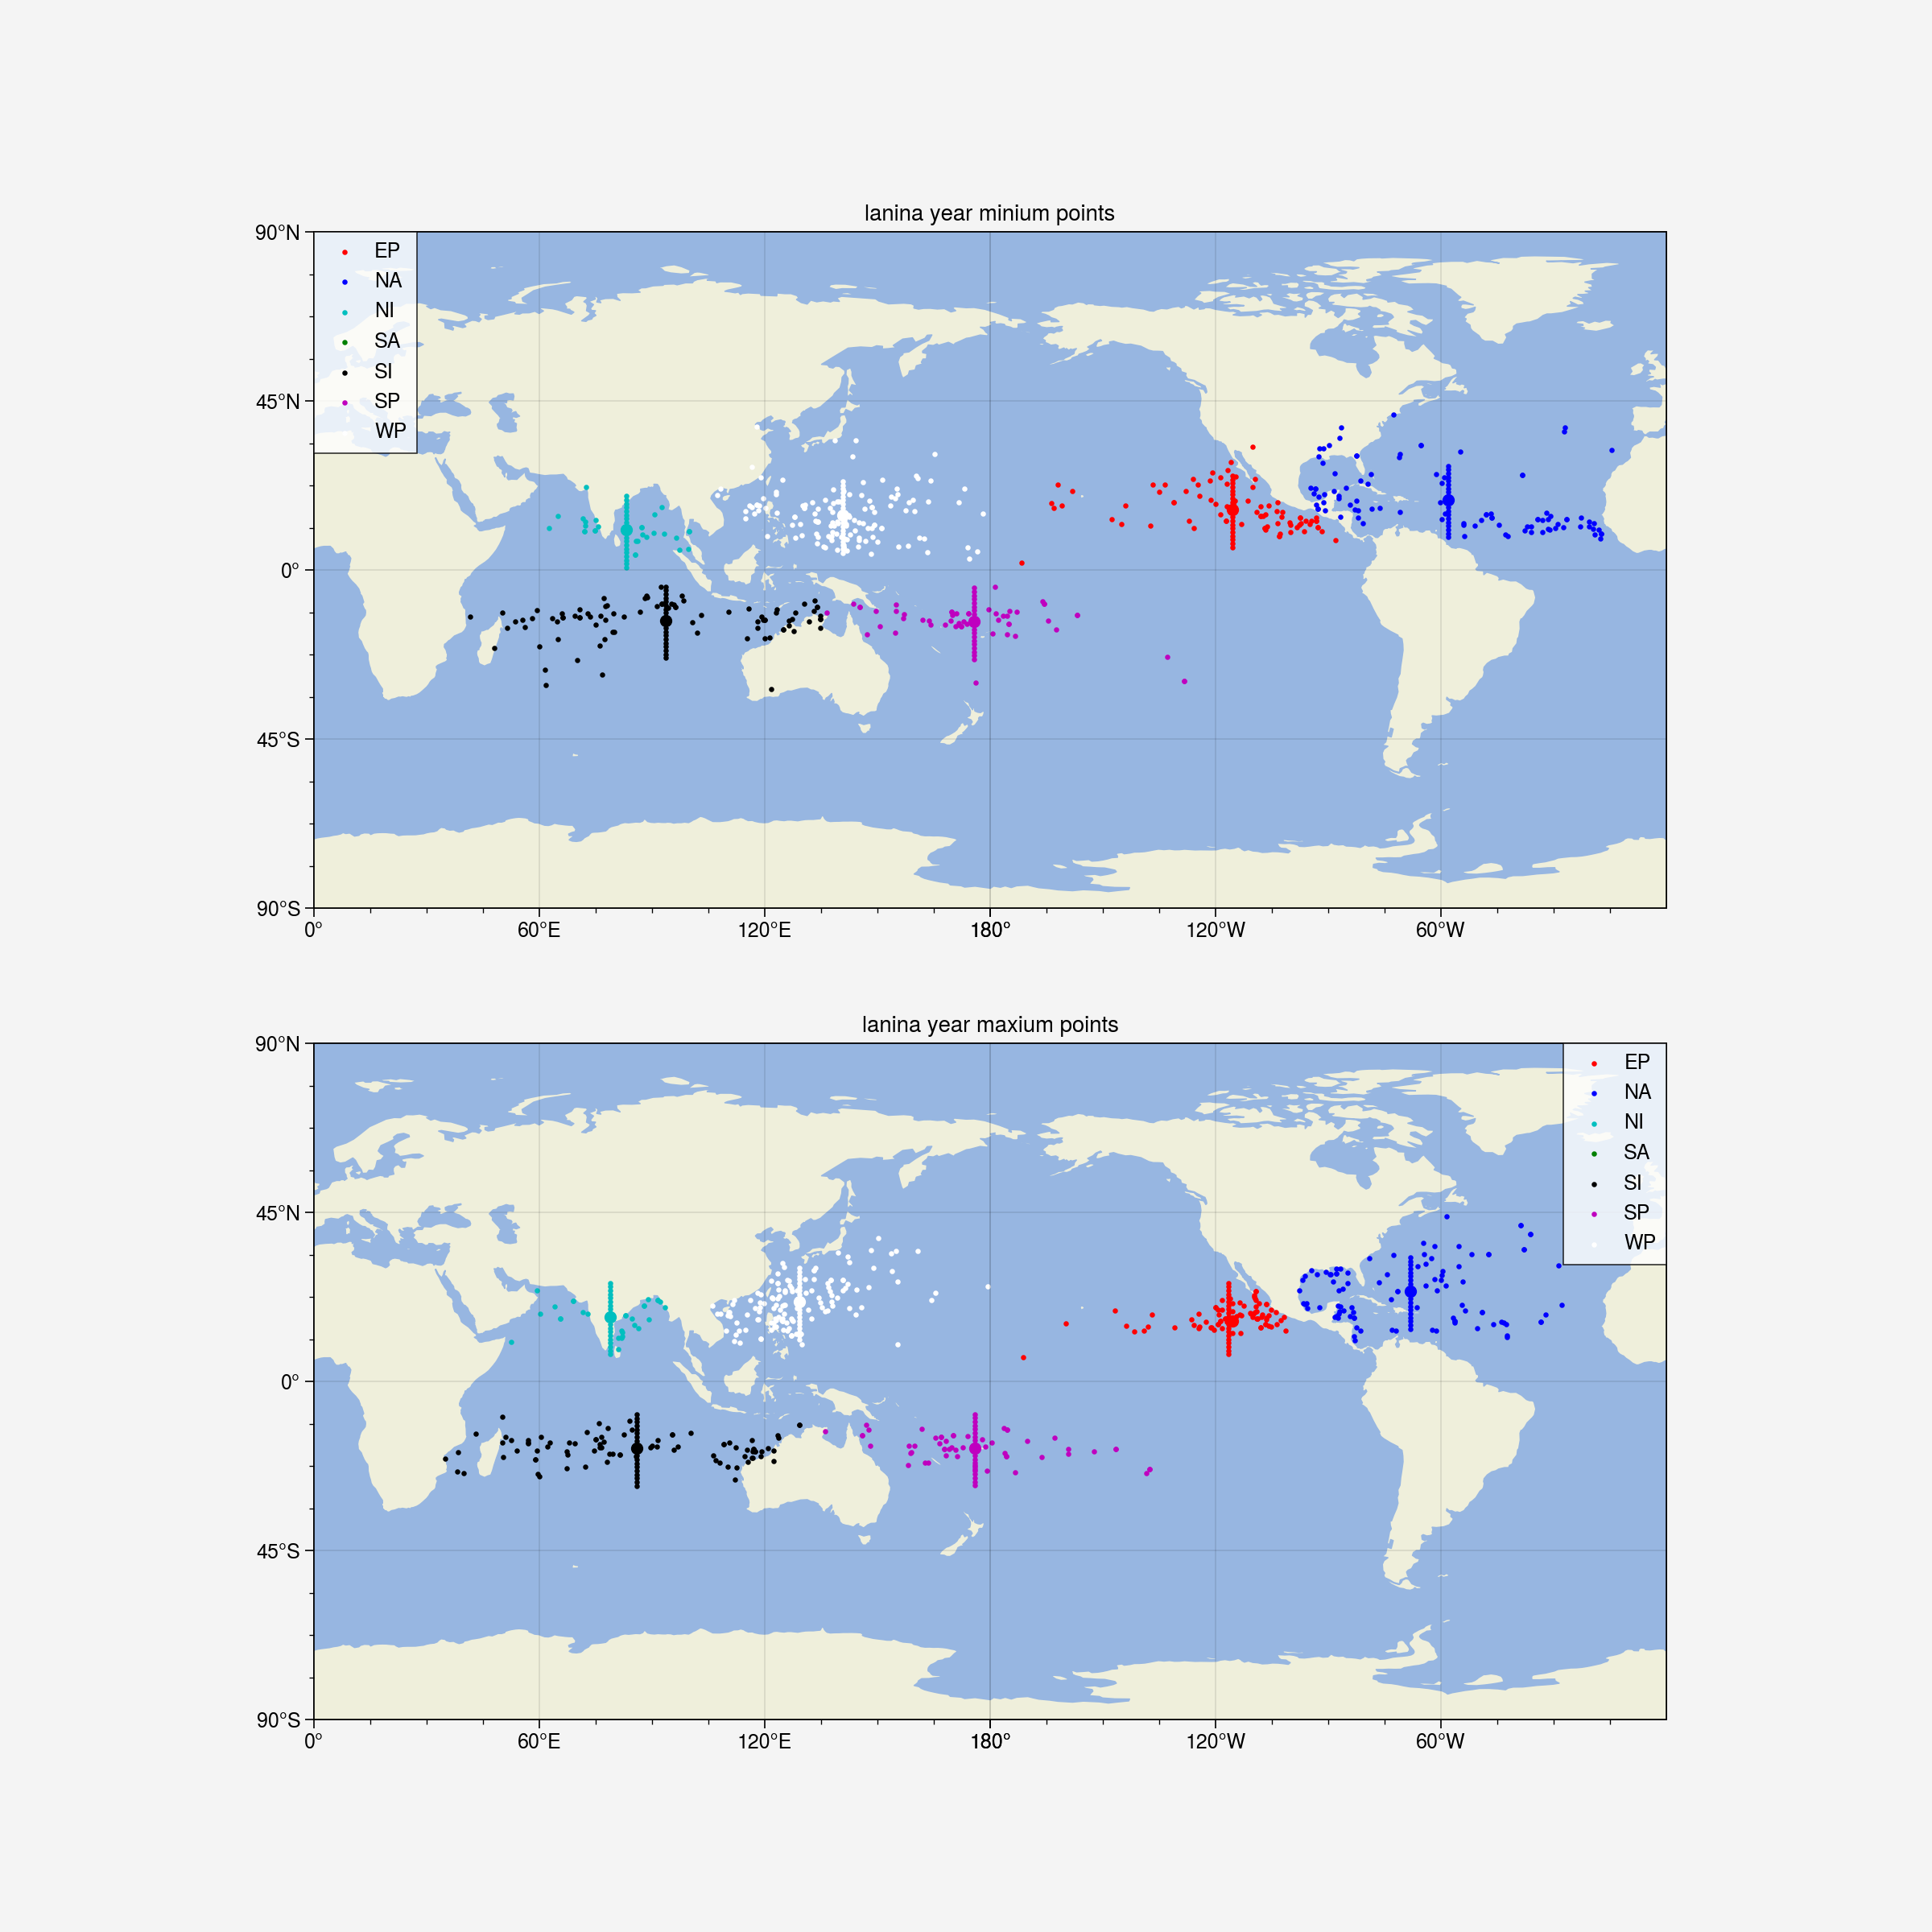

In [37]:

# basin = 'EP'  红色
df_lanina_wind_speed_min_ep, df_lanina_wind_speed_max_ep = basin_wind_speed(df, 'EP', lanina)
# basin = "NA"  蓝色
df_lanina_wind_speed_min_na, df_lanina_wind_speed_max_na = basin_wind_speed(df, 'NA', lanina)
# basin = "NI"  天蓝色
df_lanina_wind_speed_min_ni, df_lanina_wind_speed_max_ni = basin_wind_speed(df, 'NI', lanina)
# basin = "SA"  绿色
df_lanina_wind_speed_min_sa, df_lanina_wind_speed_max_sa = basin_wind_speed(df, 'SA', lanina)
# basin = "SI" 黑色
df_lanina_wind_speed_min_si, df_lanina_wind_speed_max_si = basin_wind_speed(df, 'SI', lanina)
# basin = "SP" 紫色
df_lanina_wind_speed_min_sp, df_lanina_wind_speed_max_sp = basin_wind_speed(df, 'SP', lanina)
# basin = "WP" 白色
df_lanina_wind_speed_min_wp, df_lanina_wind_speed_max_wp = basin_wind_speed(df, 'WP', lanina)

map_proj = ccrs.PlateCarree(central_longitude=180)
tick_proj = ccrs.PlateCarree(central_longitude=0)

fig, ax = plt.subplots(
    nrows=2, ncols=1, figsize=(12, 12),
    subplot_kw={'projection': map_proj}
)

ax =fig.add_subplot(2,1,1,projection=map_proj)
ax.set_global()
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.set_xticks(np.linspace(-180, 180, 7), crs=tick_proj)
ax.set_yticks(np.linspace(-90, 90, 5), crs=tick_proj)
ax.xaxis.set_major_formatter(LongitudeFormatter())
ax.yaxis.set_major_formatter(LatitudeFormatter())
ax.set_title("lanina year minium points")
# basin = 'EP'  红色
ax.scatter(df_lanina_wind_speed_min_ep['LON'], df_lanina_wind_speed_min_ep['LAT'],
        s=3, c = 'r', marker = 'o', label='EP',
        transform=ccrs.PlateCarree())
df_lanina_wind_speed_min_ep['LON'] = more_than_180(df_lanina_wind_speed_min_ep, 'LON')
lon_mean_ep_min, lat_mean_ep_min = mean_lon_lat(df_lanina_wind_speed_min_ep)
# 竖线
ax.scatter([lon_mean_ep_min for _ in range(20)], 
           np.arange(lat_mean_ep_min-10, lat_mean_ep_min + 10, 1).tolist(), 
           s=3, c = 'r', marker = 'o', 
        transform=ccrs.PlateCarree())
# 点
ax.scatter([lon_mean_ep_min], [lat_mean_ep_min],s=24, c = 'r', marker = 'o', 
        transform=ccrs.PlateCarree())

# basin = "NA"  蓝色
ax.scatter(df_lanina_wind_speed_min_na['LON'], df_lanina_wind_speed_min_na['LAT'],
        s=3, c = 'b', marker = 'o', label='NA',
        transform=ccrs.PlateCarree())
lon_mean_na_min, lat_mean_na_min = mean_lon_lat(df_lanina_wind_speed_min_na)
# 竖线
ax.scatter([lon_mean_na_min for _ in range(20)], 
           np.arange(lat_mean_na_min-10, lat_mean_na_min + 10, 1).tolist(), 
           s=3, c = 'b', marker = 'o', 
        transform=ccrs.PlateCarree())
# 点
ax.scatter([lon_mean_na_min], [lat_mean_na_min],s=24, c = 'b', marker = 'o', 
        transform=ccrs.PlateCarree())

# basin = "NI"  天蓝色
ax.scatter(df_lanina_wind_speed_min_ni['LON'], df_lanina_wind_speed_min_ni['LAT'],
        s=3, c = 'c', marker = 'o', label='NI',
        transform=ccrs.PlateCarree())
lon_mean_ni_min, lat_mean_ni_min = mean_lon_lat(df_lanina_wind_speed_min_ni)
# 竖线
ax.scatter([lon_mean_ni_min for _ in range(20)], 
           np.arange(lat_mean_ni_min-10, lat_mean_ni_min + 10, 1).tolist(), 
           s=3, c = 'c', marker = 'o', 
        transform=ccrs.PlateCarree())
# 点
ax.scatter([lon_mean_ni_min], [lat_mean_ni_min],s=24, c = 'c', marker = 'o', 
        transform=ccrs.PlateCarree())

# basin = "SA"  绿色
ax.scatter(df_lanina_wind_speed_min_sa['LON'], df_lanina_wind_speed_min_sa['LAT'],
        s=3, c = 'g', marker = 'o', label="SA",
        transform=ccrs.PlateCarree())

# basin = "SI" 黑色
ax.scatter(df_lanina_wind_speed_min_si['LON'], df_lanina_wind_speed_min_si['LAT'],
        s=3, c = 'k', marker = 'o', label='SI',
        transform=ccrs.PlateCarree())
lon_mean_si_min, lat_mean_si_min = mean_lon_lat(df_lanina_wind_speed_min_si)
# 竖线
ax.scatter([lon_mean_si_min for _ in range(20)], 
           np.arange(lat_mean_si_min-10, lat_mean_si_min + 10, 1).tolist(), 
           s=3, c = 'k', marker = 'o', 
        transform=ccrs.PlateCarree())
# 点
ax.scatter([lon_mean_si_min], [lat_mean_si_min],s=24, c = 'k', marker = 'o', 
        transform=ccrs.PlateCarree())

# basin = "SP" 紫色
ax.scatter(df_lanina_wind_speed_min_sp['LON'], df_lanina_wind_speed_min_sp['LAT'],
        s=3, c = 'm', marker = 'o', label='SP',
        transform=ccrs.PlateCarree())
# 小于0的数均加上360
df_lanina_wind_speed_min_sp['LON'] = df_lanina_wind_speed_min_sp['LON'].mask(df_lanina_wind_speed_min_sp['LON'] < 0, (df_lanina_wind_speed_min_sp['LON'] + 360))
lon_mean_sp_min = round(df_lanina_wind_speed_min_sp["LON"].mean(), 2)
lat_mean_sp_min = round(df_lanina_wind_speed_min_sp["LAT"].mean(), 2)
# 竖线
ax.scatter([lon_mean_sp_min for _ in range(20)], 
           np.arange(lat_mean_sp_min-10, lat_mean_sp_min + 10, 1).tolist(), 
           s=3, c = 'm', marker = 'o', 
        transform=ccrs.PlateCarree())
# 点
ax.scatter([lon_mean_sp_min], [lat_mean_sp_min],s=24, c = 'm', marker = 'o', 
        transform=ccrs.PlateCarree())

# basin = "WP" 白色
ax.scatter(df_lanina_wind_speed_min_wp['LON'], df_lanina_wind_speed_min_wp['LAT'],
        s=3, c = 'w', marker = 'o',  label='WP',
        transform=ccrs.PlateCarree())
lon_mean_wp_min, lat_mean_wp_min = mean_lon_lat(df_lanina_wind_speed_min_wp)
# 竖线
ax.scatter([lon_mean_wp_min for _ in range(20)], 
           np.arange(lat_mean_wp_min-10, lat_mean_wp_min + 10, 1).tolist(), 
           s=3, c = 'w', marker = 'o', 
        transform=ccrs.PlateCarree())
# 点
ax.scatter([lon_mean_wp_min], [lat_mean_wp_min],s=24, c = 'w', marker = 'o', 
        transform=ccrs.PlateCarree())
plt.legend()

# ================ 图2 =======================

ax1 =fig.add_subplot(2,1,2,projection=map_proj)
ax1.set_global()
ax1.add_feature(cfeature.LAND)
ax1.add_feature(cfeature.OCEAN)
ax1.set_xticks(np.linspace(-180, 180, 7), crs=tick_proj)
ax1.set_yticks(np.linspace(-90, 90, 5), crs=tick_proj)
ax1.xaxis.set_major_formatter(LongitudeFormatter())
ax1.yaxis.set_major_formatter(LatitudeFormatter())
ax1.set_title("lanina year maxium points")
# basin = 'EP'  红色
ax1.scatter(df_lanina_wind_speed_max_ep['LON'], df_lanina_wind_speed_max_ep['LAT'],
        s=3, c = 'r', marker = 'o', label='EP',
        transform=ccrs.PlateCarree())
df_lanina_wind_speed_max_ep['LON'] = more_than_180(df_lanina_wind_speed_max_ep, 'LON')
lon_mean_ep_max, lat_mean_ep_max = mean_lon_lat(df_lanina_wind_speed_max_ep)
# 竖线
ax1.scatter([lon_mean_ep_max for _ in range(20)], 
           np.arange(lat_mean_ep_max-10, lat_mean_ep_max + 10, 1).tolist(), 
           s=3, c = 'r', marker = 'o', 
        transform=ccrs.PlateCarree())
# 点
ax1.scatter([lon_mean_ep_min], [lat_mean_ep_min],s=24, c = 'r', marker = 'o', 
        transform=ccrs.PlateCarree())

# basin = "NA"  蓝色
ax1.scatter(df_lanina_wind_speed_max_na['LON'], df_lanina_wind_speed_max_na['LAT'],
        s=3, c = 'b', marker = 'o', label='NA',
        transform=ccrs.PlateCarree())
lon_mean_na_max, lat_mean_na_max = mean_lon_lat(df_lanina_wind_speed_max_na)
# 竖线
ax1.scatter([lon_mean_na_max for _ in range(20)], 
           np.arange(lat_mean_na_max - 10, lat_mean_na_max + 9, 1).tolist(), 
           s=3, c = 'b', marker = 'o', 
        transform=ccrs.PlateCarree())
# 点
ax1.scatter([lon_mean_na_max], [lat_mean_na_max],s=24, c = 'b', marker = 'o', 
        transform=ccrs.PlateCarree())

# basin = "NI"  天蓝色
ax1.scatter(df_lanina_wind_speed_max_ni['LON'], df_lanina_wind_speed_max_ni['LAT'],
        s=3, c = 'c', marker = 'o', label='NI',
        transform=ccrs.PlateCarree())
lon_mean_ni_max, lat_mean_ni_max = mean_lon_lat(df_lanina_wind_speed_max_ni)
# 竖线
ax1.scatter([lon_mean_ni_max for _ in range(20)], 
           np.arange(lat_mean_ni_max-10, lat_mean_ni_max + 10, 1).tolist(), 
           s=3, c = 'c', marker = 'o', 
        transform=ccrs.PlateCarree())
# 点
ax1.scatter([lon_mean_ni_max], [lat_mean_ni_max],s=24, c = 'c', marker = 'o', 
        transform=ccrs.PlateCarree())

# basin = "SA"  绿色
ax1.scatter(df_lanina_wind_speed_max_sa['LON'], df_lanina_wind_speed_max_sa['LAT'],
        s=3, c = 'g', marker = 'o', label="SA",
        transform=ccrs.PlateCarree())

# basin = "SI" 黑色
ax1.scatter(df_lanina_wind_speed_max_si['LON'], df_lanina_wind_speed_max_si['LAT'],
        s=3, c = 'k', marker = 'o', label='SI',
        transform=ccrs.PlateCarree())
lon_mean_si_max, lat_mean_si_max = mean_lon_lat(df_lanina_wind_speed_max_si)
# 竖线
ax1.scatter([lon_mean_si_max for _ in range(20)], 
           np.arange(lat_mean_si_max-10, lat_mean_si_max + 10, 1).tolist(), 
           s=3, c = 'k', marker = 'o', 
        transform=ccrs.PlateCarree())
# 点
ax1.scatter([lon_mean_si_max], [lat_mean_si_max],s=24, c = 'k', marker = 'o', 
        transform=ccrs.PlateCarree())

# basin = "SP" 紫色
ax1.scatter(df_lanina_wind_speed_max_sp['LON'], df_lanina_wind_speed_max_sp['LAT'],
        s=3, c = 'm', marker = 'o', label='SP',
        transform=ccrs.PlateCarree())
# 小于0的数均加上360
df_lanina_wind_speed_max_sp['LON'] = df_lanina_wind_speed_max_sp['LON'].mask(df_lanina_wind_speed_max_sp['LON'] < 0, (df_lanina_wind_speed_max_sp['LON'] + 360))
lon_mean_sp_max = round(df_lanina_wind_speed_max_sp["LON"].mean(), 2)
lat_mean_sp_max = round(df_lanina_wind_speed_max_sp["LAT"].mean(), 2)
# 竖线
ax1.scatter([lon_mean_sp_max for _ in range(20)], 
           np.arange(lat_mean_sp_max-10, lat_mean_sp_max + 10, 1).tolist(), 
           s=3, c = 'm', marker = 'o', 
        transform=ccrs.PlateCarree())
# 点
ax1.scatter([lon_mean_sp_max], [lat_mean_sp_max],s=24, c = 'm', marker = 'o', 
        transform=ccrs.PlateCarree())

# basin = "WP" 白色
ax1.scatter(df_lanina_wind_speed_max_wp['LON'], df_lanina_wind_speed_max_wp['LAT'],
        s=3, c = 'w', marker = 'o', label='WP',
        transform=ccrs.PlateCarree())
lon_mean_wp_max, lat_mean_wp_max = mean_lon_lat(df_lanina_wind_speed_max_wp)
# 竖线
ax1.scatter([lon_mean_wp_max for _ in range(20)], 
           np.arange(lat_mean_wp_max-10, lat_mean_wp_max + 10, 1).tolist(), 
           s=3, c = 'w', marker = 'o', 
        transform=ccrs.PlateCarree())
# 点
ax1.scatter([lon_mean_wp_max], [lat_mean_wp_max],s=24, c = 'w', marker = 'o', 
        transform=ccrs.PlateCarree())

plt.legend()

# fig = plt.figure(figsize=[20, 20])

print("The Minium Wind average lon and lat point is (%.2f, %.2f) at Lanina year in EP basin."%(lon_mean_ep_min, lat_mean_ep_min))
print("The Minium Wind average lon and lat point is (%.2f, %.2f) at Lanina year in NA basin."%(lon_mean_na_min, lat_mean_na_min))
print("The Minium Wind average lon and lat point is (%.2f, %.2f) at Lanina year in NI basin."%(lon_mean_ni_min, lat_mean_ni_min))
print("The Minium Wind average lon and lat point is (%.2f, %.2f) at Lanina year in SI basin."%(lon_mean_si_min, lat_mean_si_min))
print("The Minium Wind average lon and lat point is (%.2f, %.2f) at Lanina year in SP basin."%(lon_mean_sp_min, lat_mean_sp_min))
print("The Minium Wind average lon and lat point is (%.2f, %.2f) at Lanina year in WP basin."%(lon_mean_wp_min, lat_mean_wp_min))
print("------分割线--------")
print("The Maxium Wind average lon and lat point is (%.2f, %.2f) at Lanina year in EP basin."%(lon_mean_ep_max, lat_mean_ep_max))
print("The Maxium Wind average lon and lat point is (%.2f, %.2f) at Lanina year in NA basin."%(lon_mean_na_max, lat_mean_na_max))
print("The Maxium Wind average lon and lat point is (%.2f, %.2f) at Lanina year in NI basin."%(lon_mean_ni_max, lat_mean_ni_max))
print("The Maxium Wind average lon and lat point is (%.2f, %.2f) at Lanina year in SI basin."%(lon_mean_si_max, lat_mean_si_max))
print("The Maxium Wind average lon and lat point is (%.2f, %.2f) at Lanina year in SP basin."%(lon_mean_sp_max, lat_mean_sp_max))
print("The Maxium Wind average lon and lat point is (%.2f, %.2f) at Lanina year in WP basin."%(lon_mean_wp_max, lat_mean_wp_max))

The Minium Wind average lon and lat point is (-117.38, 17.65) at Neutrual year in EP basin.
The Minium Wind average lon and lat point is (-59.75, 22.01) at Neutrual year in NA basin.
The Minium Wind average lon and lat point is (82.14, 11.19) at Neutrual year in NI basin.
The Minium Wind average lon and lat point is (85.13, -12.78) at Neutrual year in SI basin.
The Minium Wind average lon and lat point is (172.26, -13.39) at Neutrual year in SP basin.
The Minium Wind average lon and lat point is (144.79, 12.88) at Neutrual year in WP basin.
------分割线--------
The Maxium Wind average lon and lat point is (-118.15, 17.09) at Neutrual year in EP basin.
The Maxium Wind average lon and lat point is (-66.19, 26.73) at Neutrual year in NA basin.
The Maxium Wind average lon and lat point is (78.01, 15.75) at Neutrual year in NI basin.
The Maxium Wind average lon and lat point is (78.77, -16.94) at Neutrual year in SI basin.
The Maxium Wind average lon and lat point is (170.94, -17.54) at Neutru

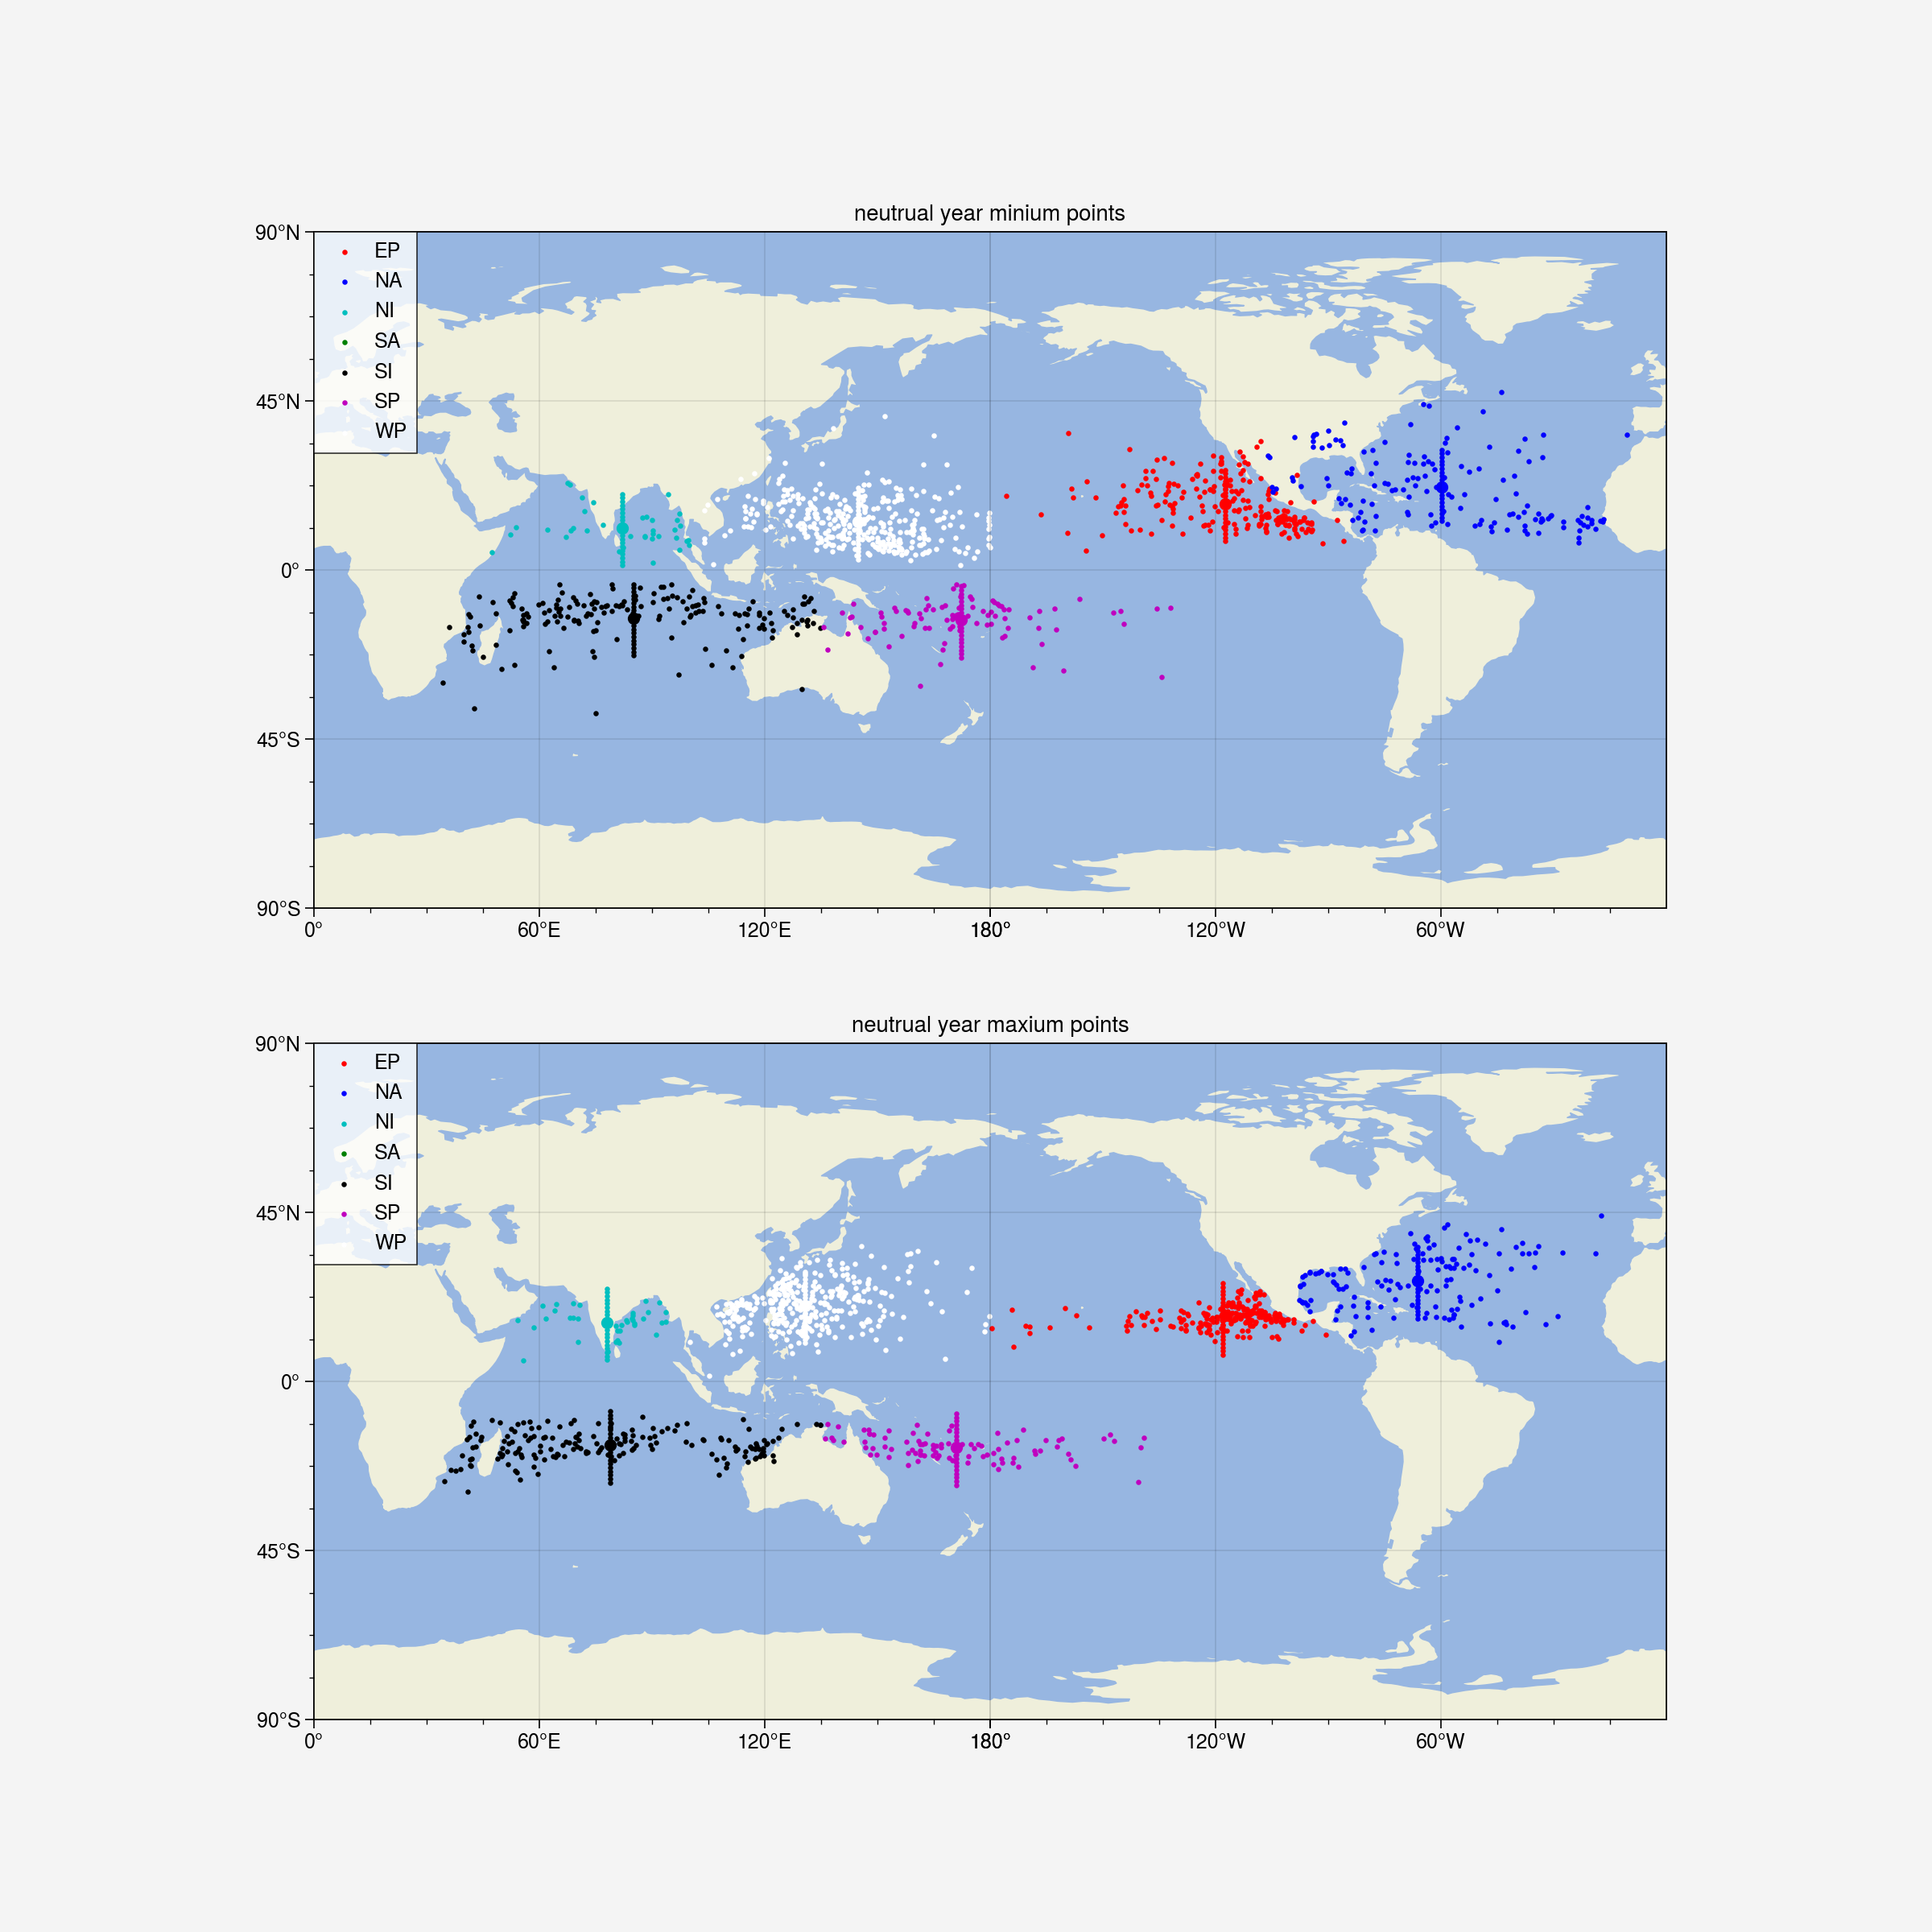

In [38]:
# basin = 'EP'  红色
df_neutrual_wind_speed_min_ep, df_neutrual_wind_speed_max_ep = basin_wind_speed(df, 'EP', neutrual)
# basin = "NA"  蓝色
df_neutrual_wind_speed_min_na, df_neutrual_wind_speed_max_na = basin_wind_speed(df, 'NA', neutrual)
# basin = "NI"  天蓝色
df_neutrual_wind_speed_min_ni, df_neutrual_wind_speed_max_ni = basin_wind_speed(df, 'NI', neutrual)
# basin = "SA"  绿色
df_neutrual_wind_speed_min_sa, df_neutrual_wind_speed_max_sa = basin_wind_speed(df, 'SA', neutrual)
# basin = "SI" 黑色
df_neutrual_wind_speed_min_si, df_neutrual_wind_speed_max_si = basin_wind_speed(df, 'SI', neutrual)
# basin = "SP" 紫色
df_neutrual_wind_speed_min_sp, df_neutrual_wind_speed_max_sp = basin_wind_speed(df, 'SP', neutrual)
# basin = "WP" 白色
df_neutrual_wind_speed_min_wp, df_neutrual_wind_speed_max_wp = basin_wind_speed(df, 'WP', neutrual)

map_proj = ccrs.PlateCarree(central_longitude=180)
tick_proj = ccrs.PlateCarree(central_longitude=0)

fig, ax = plt.subplots(
    nrows=2, ncols=1, figsize=(12, 12),
    subplot_kw={'projection': map_proj}
)

ax =fig.add_subplot(2,1,1,projection=map_proj)
ax.set_global()
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.set_xticks(np.linspace(-180, 180, 7), crs=tick_proj)
ax.set_yticks(np.linspace(-90, 90, 5), crs=tick_proj)
ax.xaxis.set_major_formatter(LongitudeFormatter())
ax.yaxis.set_major_formatter(LatitudeFormatter())
ax.set_title("neutrual year minium points")
# basin = 'EP'  红色
ax.scatter(df_neutrual_wind_speed_min_ep['LON'], df_neutrual_wind_speed_min_ep['LAT'],
        s=3, c = 'r', marker = 'o', label='EP',
        transform=ccrs.PlateCarree())
df_neutrual_wind_speed_min_ep['LON'] = more_than_180(df_neutrual_wind_speed_min_ep, 'LON')
lon_mean_ep_min, lat_mean_ep_min = mean_lon_lat(df_neutrual_wind_speed_min_ep)
# 竖线
ax.scatter([lon_mean_ep_min for _ in range(20)], 
           np.arange(lat_mean_ep_min-10, lat_mean_ep_min + 10, 1).tolist(), 
           s=3, c = 'r', marker = 'o', 
        transform=ccrs.PlateCarree())
# 点
ax.scatter([lon_mean_ep_min], [lat_mean_ep_min],s=24, c = 'r', marker = 'o', 
        transform=ccrs.PlateCarree())

# basin = "NA"  蓝色
ax.scatter(df_neutrual_wind_speed_min_na['LON'], df_neutrual_wind_speed_min_na['LAT'],
        s=3, c = 'b', marker = 'o', label='NA',
        transform=ccrs.PlateCarree())
lon_mean_na_min, lat_mean_na_min = mean_lon_lat(df_neutrual_wind_speed_min_na)
# 竖线
ax.scatter([lon_mean_na_min for _ in range(20)], 
           np.arange(lat_mean_na_min-9, lat_mean_na_min + 10, 1).tolist(), 
           s=3, c = 'b', marker = 'o', 
        transform=ccrs.PlateCarree())
# 点
ax.scatter([lon_mean_na_min], [lat_mean_na_min],s=24, c = 'b', marker = 'o', 
        transform=ccrs.PlateCarree())

# basin = "NI"  天蓝色
ax.scatter(df_neutrual_wind_speed_min_ni['LON'], df_neutrual_wind_speed_min_ni['LAT'],
        s=3, c = 'c', marker = 'o', label='NI',
        transform=ccrs.PlateCarree())
lon_mean_ni_min, lat_mean_ni_min = mean_lon_lat(df_neutrual_wind_speed_min_ni)
# 竖线
ax.scatter([lon_mean_ni_min for _ in range(20)], 
           np.arange(lat_mean_ni_min-10, lat_mean_ni_min + 10, 1).tolist(), 
           s=3, c = 'c', marker = 'o', 
        transform=ccrs.PlateCarree())
# 点
ax.scatter([lon_mean_ni_min], [lat_mean_ni_min],s=24, c = 'c', marker = 'o', 
        transform=ccrs.PlateCarree())

# basin = "SA"  绿色
ax.scatter(df_neutrual_wind_speed_min_sa['LON'], df_neutrual_wind_speed_min_sa['LAT'],
        s=3, c = 'g', marker = 'o', label="SA",
        transform=ccrs.PlateCarree())

# basin = "SI" 黑色
ax.scatter(df_neutrual_wind_speed_min_si['LON'], df_neutrual_wind_speed_min_si['LAT'],
        s=3, c = 'k', marker = 'o', label='SI',
        transform=ccrs.PlateCarree())
lon_mean_si_min, lat_mean_si_min = mean_lon_lat(df_neutrual_wind_speed_min_si)
# 竖线
ax.scatter([lon_mean_si_min for _ in range(20)], 
           np.arange(lat_mean_si_min-10, lat_mean_si_min + 10, 1).tolist(), 
           s=3, c = 'k', marker = 'o', 
        transform=ccrs.PlateCarree())
# 点
ax.scatter([lon_mean_si_min], [lat_mean_si_min],s=24, c = 'k', marker = 'o', 
        transform=ccrs.PlateCarree())

# basin = "SP" 紫色
ax.scatter(df_neutrual_wind_speed_min_sp['LON'], df_neutrual_wind_speed_min_sp['LAT'],
        s=3, c = 'm', marker = 'o', label='SP',
        transform=ccrs.PlateCarree())
# 小于0的数均加上360
df_neutrual_wind_speed_min_sp['LON'] = df_neutrual_wind_speed_min_sp['LON'].mask(df_neutrual_wind_speed_min_sp['LON'] < 0, (df_neutrual_wind_speed_min_sp['LON'] + 360))
lon_mean_sp_min = round(df_neutrual_wind_speed_min_sp["LON"].mean(), 2)
lat_mean_sp_min = round(df_neutrual_wind_speed_min_sp["LAT"].mean(), 2)
# 竖线
ax.scatter([lon_mean_sp_min for _ in range(20)], 
           np.arange(lat_mean_sp_min-10, lat_mean_sp_min + 10, 1).tolist(), 
           s=3, c = 'm', marker = 'o', 
        transform=ccrs.PlateCarree())
# 点
ax.scatter([lon_mean_sp_min], [lat_mean_sp_min],s=24, c = 'm', marker = 'o', 
        transform=ccrs.PlateCarree())

# basin = "WP" 白色
ax.scatter(df_neutrual_wind_speed_min_wp['LON'], df_neutrual_wind_speed_min_wp['LAT'],
        s=3, c = 'w', marker = 'o',  label='WP',
        transform=ccrs.PlateCarree())
lon_mean_wp_min, lat_mean_wp_min = mean_lon_lat(df_neutrual_wind_speed_min_wp)
# 竖线
ax.scatter([lon_mean_wp_min for _ in range(20)], 
           np.arange(lat_mean_wp_min-10, lat_mean_wp_min + 10, 1).tolist(), 
           s=3, c = 'w', marker = 'o', 
        transform=ccrs.PlateCarree())
# 点
ax.scatter([lon_mean_wp_min], [lat_mean_wp_min],s=24, c = 'w', marker = 'o', 
        transform=ccrs.PlateCarree())
plt.legend()


# ===================图2 =================

ax1 =fig.add_subplot(2,1,2,projection=map_proj)
ax1.set_global()
ax1.add_feature(cfeature.LAND)
ax1.add_feature(cfeature.OCEAN)
ax1.set_xticks(np.linspace(-180, 180, 7), crs=tick_proj)
ax1.set_yticks(np.linspace(-90, 90, 5), crs=tick_proj)
ax1.xaxis.set_major_formatter(LongitudeFormatter())
ax1.yaxis.set_major_formatter(LatitudeFormatter())
ax1.set_title("neutrual year maxium points")
# basin = 'EP'  红色
ax1.scatter(df_neutrual_wind_speed_max_ep['LON'], df_neutrual_wind_speed_max_ep['LAT'],
        s=3, c = 'r', marker = 'o', label='EP',
        transform=ccrs.PlateCarree())
df_neutrual_wind_speed_max_ep['LON'] = more_than_180(df_neutrual_wind_speed_max_ep, 'LON')
lon_mean_ep_max, lat_mean_ep_max = mean_lon_lat(df_neutrual_wind_speed_max_ep)
# 竖线
ax1.scatter([lon_mean_ep_max for _ in range(20)], 
           np.arange(lat_mean_ep_max-10, lat_mean_ep_max + 10, 1).tolist(), 
           s=3, c = 'r', marker = 'o', 
        transform=ccrs.PlateCarree())
# 点
ax1.scatter([lon_mean_ep_min], [lat_mean_ep_min],s=24, c = 'r', marker = 'o', 
        transform=ccrs.PlateCarree())

# basin = "NA"  蓝色
ax1.scatter(df_neutrual_wind_speed_max_na['LON'], df_neutrual_wind_speed_max_na['LAT'],
        s=3, c = 'b', marker = 'o', label='NA',
        transform=ccrs.PlateCarree())
lon_mean_na_max, lat_mean_na_max = mean_lon_lat(df_neutrual_wind_speed_max_na)
# 竖线
ax1.scatter([lon_mean_na_max for _ in range(20)], 
           np.arange(lat_mean_na_max - 10, lat_mean_na_max + 9, 1).tolist(), 
           s=3, c = 'b', marker = 'o', 
        transform=ccrs.PlateCarree())
# 点
ax1.scatter([lon_mean_na_max], [lat_mean_na_max],s=24, c = 'b', marker = 'o', 
        transform=ccrs.PlateCarree())

# basin = "NI"  天蓝色
ax1.scatter(df_neutrual_wind_speed_max_ni['LON'], df_neutrual_wind_speed_max_ni['LAT'],
        s=3, c = 'c', marker = 'o', label='NI',
        transform=ccrs.PlateCarree())
lon_mean_ni_max, lat_mean_ni_max = mean_lon_lat(df_neutrual_wind_speed_max_ni)
# 竖线
ax1.scatter([lon_mean_ni_max for _ in range(20)], 
           np.arange(lat_mean_ni_max-10, lat_mean_ni_max + 10, 1).tolist(), 
           s=3, c = 'c', marker = 'o', 
        transform=ccrs.PlateCarree())
# 点
ax1.scatter([lon_mean_ni_max], [lat_mean_ni_max],s=24, c = 'c', marker = 'o', 
        transform=ccrs.PlateCarree())

# basin = "SA"  绿色
ax1.scatter(df_neutrual_wind_speed_max_sa['LON'], df_neutrual_wind_speed_max_sa['LAT'],
        s=3, c = 'g', marker = 'o', label="SA",
        transform=ccrs.PlateCarree())

# basin = "SI" 黑色
ax1.scatter(df_neutrual_wind_speed_max_si['LON'], df_neutrual_wind_speed_max_si['LAT'],
        s=3, c = 'k', marker = 'o', label='SI',
        transform=ccrs.PlateCarree())
lon_mean_si_max, lat_mean_si_max = mean_lon_lat(df_neutrual_wind_speed_max_si)
# 竖线
ax1.scatter([lon_mean_si_max for _ in range(20)], 
           np.arange(lat_mean_si_max-10, lat_mean_si_max + 10, 1).tolist(), 
           s=3, c = 'k', marker = 'o', 
        transform=ccrs.PlateCarree())
# 点
ax1.scatter([lon_mean_si_max], [lat_mean_si_max],s=24, c = 'k', marker = 'o', 
        transform=ccrs.PlateCarree())

# basin = "SP" 紫色
ax1.scatter(df_neutrual_wind_speed_max_sp['LON'], df_neutrual_wind_speed_max_sp['LAT'],
        s=3, c = 'm', marker = 'o', label='SP',
        transform=ccrs.PlateCarree())
# 小于0的数均加上360
df_neutrual_wind_speed_max_sp['LON'] = df_neutrual_wind_speed_max_sp['LON'].mask(df_neutrual_wind_speed_max_sp['LON'] < 0, (df_neutrual_wind_speed_max_sp['LON'] + 360))
lon_mean_sp_max = round(df_neutrual_wind_speed_max_sp["LON"].mean(), 2)
lat_mean_sp_max = round(df_neutrual_wind_speed_max_sp["LAT"].mean(), 2)
# 竖线
ax1.scatter([lon_mean_sp_max for _ in range(20)], 
           np.arange(lat_mean_sp_max-10, lat_mean_sp_max + 10, 1).tolist(), 
           s=3, c = 'm', marker = 'o', 
        transform=ccrs.PlateCarree())
# 点
ax1.scatter([lon_mean_sp_max], [lat_mean_sp_max],s=24, c = 'm', marker = 'o', 
        transform=ccrs.PlateCarree())

# basin = "WP" 白色
ax1.scatter(df_neutrual_wind_speed_max_wp['LON'], df_neutrual_wind_speed_max_wp['LAT'],
        s=3, c = 'w', marker = 'o', label='WP',
        transform=ccrs.PlateCarree())
lon_mean_wp_max, lat_mean_wp_max = mean_lon_lat(df_neutrual_wind_speed_max_wp)
# 竖线
ax1.scatter([lon_mean_wp_max for _ in range(20)], 
           np.arange(lat_mean_wp_max-10, lat_mean_wp_max + 10, 1).tolist(), 
           s=3, c = 'w', marker = 'o', 
        transform=ccrs.PlateCarree())
# 点
ax1.scatter([lon_mean_wp_max], [lat_mean_wp_max],s=24, c = 'w', marker = 'o', 
        transform=ccrs.PlateCarree())

plt.legend()

# fig = plt.figure(figsize=[20, 20])

print("The Minium Wind average lon and lat point is (%.2f, %.2f) at Neutrual year in EP basin."%(lon_mean_ep_min, lat_mean_ep_min))
print("The Minium Wind average lon and lat point is (%.2f, %.2f) at Neutrual year in NA basin."%(lon_mean_na_min, lat_mean_na_min))
print("The Minium Wind average lon and lat point is (%.2f, %.2f) at Neutrual year in NI basin."%(lon_mean_ni_min, lat_mean_ni_min))
print("The Minium Wind average lon and lat point is (%.2f, %.2f) at Neutrual year in SI basin."%(lon_mean_si_min, lat_mean_si_min))
print("The Minium Wind average lon and lat point is (%.2f, %.2f) at Neutrual year in SP basin."%(lon_mean_sp_min, lat_mean_sp_min))
print("The Minium Wind average lon and lat point is (%.2f, %.2f) at Neutrual year in WP basin."%(lon_mean_wp_min, lat_mean_wp_min))
print("------分割线--------")
print("The Maxium Wind average lon and lat point is (%.2f, %.2f) at Neutrual year in EP basin."%(lon_mean_ep_max, lat_mean_ep_max))
print("The Maxium Wind average lon and lat point is (%.2f, %.2f) at Neutrual year in NA basin."%(lon_mean_na_max, lat_mean_na_max))
print("The Maxium Wind average lon and lat point is (%.2f, %.2f) at Neutrual year in NI basin."%(lon_mean_ni_max, lat_mean_ni_max))
print("The Maxium Wind average lon and lat point is (%.2f, %.2f) at Neutrual year in SI basin."%(lon_mean_si_max, lat_mean_si_max))
print("The Maxium Wind average lon and lat point is (%.2f, %.2f) at Neutrual year in SP basin."%(lon_mean_sp_max, lat_mean_sp_max))
print("The Maxium Wind average lon and lat point is (%.2f, %.2f) at Neutrual year in WP basin."%(lon_mean_wp_max, lat_mean_wp_max))

In [30]:
df_lanina_wind_speed_max_ep.sort_values(by='LON')

,SEASON,NUMBER,LAT,LON,USA_WIND
55,2016,1,6.40,-171.20,85.0
62,2016,55,18.90,-146.70,115.0
1,1988,40,14.70,-143.78,120.0
39,2007,43,13.20,-141.70,120.0
66,2016,73,13.60,-139.10,65.0
...,...,...,...,...,...
33,2000,39,15.13,-103.77,135.0
51,2011,69,16.20,-102.70,125.0
79,2021,37,17.20,-101.80,90.0
43,2010,31,13.60,-101.30,105.0


In [31]:
df_einino_wind_speed_max_ep.sort_values(by='LON')

,SEASON,NUMBER,LAT,LON,USA_WIND
89,2015,65,25.30,-176.70,65.0
81,2009,83,18.30,-166.70,110.0
11,1982,100,20.09,-162.92,80.0
5,1982,58,15.29,-157.69,80.0
42,1994,47,11.72,-149.60,140.0
...,...,...,...,...,...
29,1987,80,16.50,182.35,90.0
88,2015,63,18.30,183.55,120.0
67,2002,85,14.10,188.60,75.0
45,1994,64,14.18,204.88,150.0
